In [ ]:
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from google.colab import drive
import glob
import os
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
#@title Select dataset

cell_line = 'Hs766T' #@param['HT29', 'Hs766T', 'Both']
evaluate = 'pi' #@param['dapi','pi']


def import_images(im, md, path, evaluate, reset = True):
  for img in os.listdir(f"{path}bf"):
    im.append(1-cv2.resize(cv2.imread(f"{path}bf/{img}")/255.0, (256,256)))
    md.append(cv2.resize(cv2.imread(f"{path}{evaluate}_m/{img}", cv2.IMREAD_GRAYSCALE)/255.0, (256,256)))

bf_images = []
dye_images = []

if cell_line == 'HT29':
  path = "/content/drive/MyDrive/Sopheriods/ExperimentSpheroidsHT29/"
  import_images(bf_images, dye_images, path, evaluate)
elif cell_line == 'Hs766T':
  path = "/content/drive/MyDrive/Sopheriods/ExperimentPancreas/"
  import_images(bf_images, dye_images, path, evaluate)
elif cell_line == 'Both':
  path = "/content/drive/MyDrive/Sopheriods/ExperimentSpheroidsHT29/"
  import_images(bf_images, dye_images, path, evaluate)
  path = "/content/drive/MyDrive/Sopheriods/ExperimentPancreas/"
  import_images(bf_images, dye_images, path, evaluate)

In [ ]:
#@title Train-test split

X_train, X_test, y_train, y_test = train_test_split(bf_images, np.round(dye_images), test_size=0.33, random_state=40)

# Change format so that keras is happy (everything as np arrays, add an empty axis to y)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_train = y_train[..., np.newaxis]
y_test = np.asarray(y_test)
y_test = y_test[..., np.newaxis]

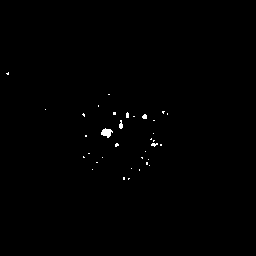

In [ ]:
#@title Quick check 1: open one image of our Y train set:
cv2_imshow((y_train[3])*255)

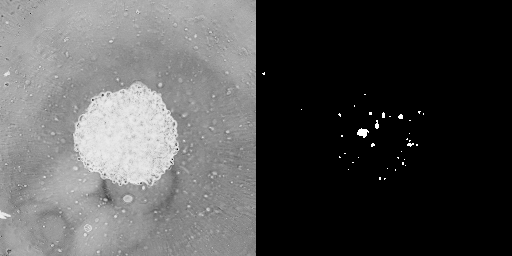

In [ ]:
#@title Quick check 2: open one pair of images of our train set:
i = 3 #@param {type: "integer"}
cv2_imshow(np.concatenate(((X_train[i]*255).astype(np.uint8),cv2.cvtColor((y_train[i]*255).astype(np.uint8),cv2.COLOR_GRAY2RGB)), axis = 1))

In [ ]:
#@title Neural Network Setup

inputs = tf.keras.layers.Input(shape=(256, 256 ,3))

kernel_size = 3 # default = 3
pool_size = 2 # default = 2
#dropout = 0.3
#n_filters = # def: [16, 32, 64, 128, 256, 128, 64, 32, 16]

def encoder(inputs):
    c1 = tf.keras.layers.Conv2D(16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.AveragePooling2D(pool_size = (2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.AveragePooling2D(pool_size = (2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.2)(c5)
    c5 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(c5)

    c6 = tf.keras.layers.Conv2D(256, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    c6 = tf.keras.layers.Conv2D(256, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    p6 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(c6)

    c6 = tf.keras.layers.Conv2D(512, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(p6)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    c6 = tf.keras.layers.Conv2D(512, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    # c6 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    # c6 = tf.keras.layers.Dropout(0.2)(c6)
    # c6 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    return c6

num_classes = 1
def decoder(c6):
    u7 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c6)
    c7 = tf.keras.layers.Conv2D(512, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Add()([u7, c7])

    u8 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c7)
    c8 = tf.keras.layers.Conv2D(256, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Add()([u8, c8])

    u9 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c8)
    c9 = tf.keras.layers.Conv2D(128, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Add()([u9, c9])

    u10 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c9)
    c10 = tf.keras.layers.Conv2D(64, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = tf.keras.layers.Add()([u10, c10])

    u11 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c10)
    c11 = tf.keras.layers.Conv2D(32, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u11)
    c11 = tf.keras.layers.Add()([u11, c11])

    u12 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c11)
    c12 = tf.keras.layers.Conv2D(16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u12)
    c12 = tf.keras.layers.Add()([u12, c12])

    # u13 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c12)
    # c13 = tf.keras.layers.Conv2D(16, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same')(u13)
    # c13 = tf.keras.layers.Add()([u13, c13])

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c12)
    return outputs

encoder = encoder(inputs)
outputs = decoder(encoder)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

model.summary()

In [ ]:
#@title Train Neural Network

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["binary_accuracy"])

model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=30, callbacks=callbacks)


Epoch 1/30
20/20 [==============================] - 16s 55ms/step - loss: 0.5549 - binary_accuracy: 0.9552 - val_loss: 0.1231 - val_binary_accuracy: 0.9945
Epoch 2/30
20/20 [==============================] - 0s 23ms/step - loss: 0.0719 - binary_accuracy: 0.9968 - val_loss: 0.0294 - val_binary_accuracy: 0.9970
Epoch 3/30
20/20 [==============================] - 0s 23ms/step - loss: 0.0499 - binary_accuracy: 0.9972 - val_loss: 0.0341 - val_binary_accuracy: 0.9970
Epoch 4/30
20/20 [==============================] - 0s 22ms/step - loss: 0.0244 - binary_accuracy: 0.9972 - val_loss: 0.0261 - val_binary_accuracy: 0.9970
Epoch 5/30
20/20 [==============================] - 0s 22ms/step - loss: 0.0178 - binary_accuracy: 0.9972 - val_loss: 0.0177 - val_binary_accuracy: 0.9970
Epoch 6/30
20/20 [==============================] - 0s 22ms/step - loss: 0.0161 - binary_accuracy: 0.9972 - val_loss: 0.0174 - val_binary_accuracy: 0.9970
Epoch 7/30
20/20 [==============================] - 0s 23ms/step - lo

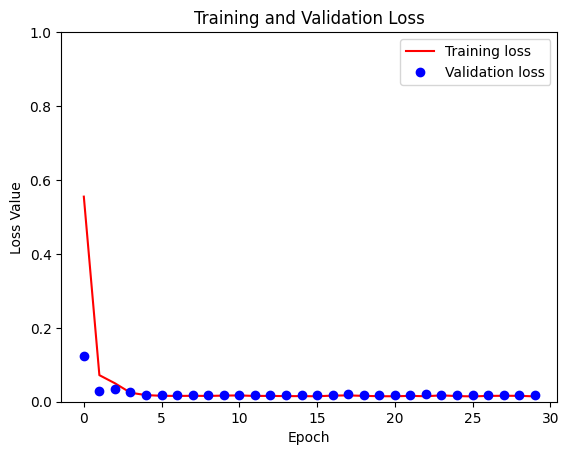

In [ ]:
#@title Training / Validation Loss curve

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step


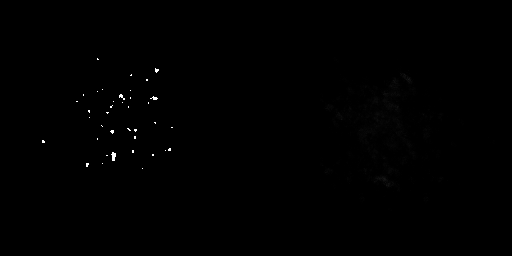

0.0


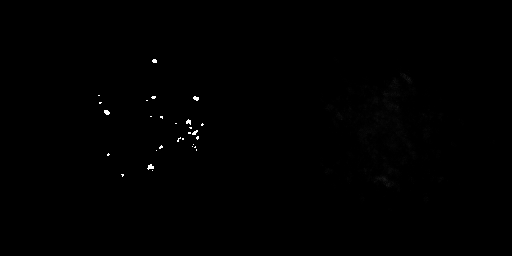

0.0


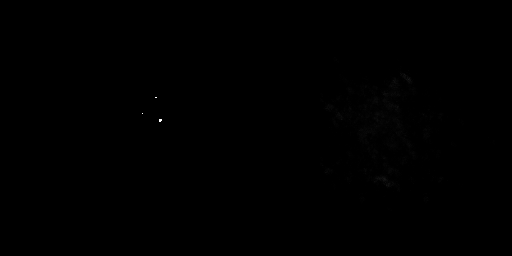

0.0


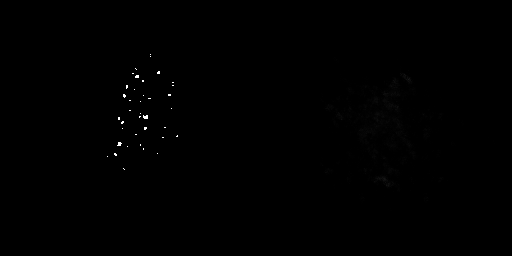

0.0


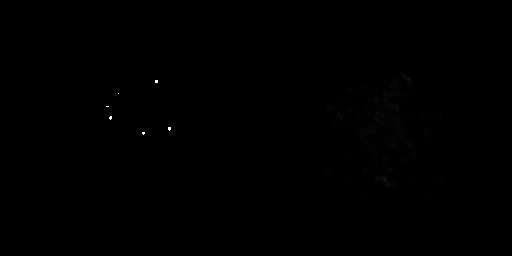

0.0


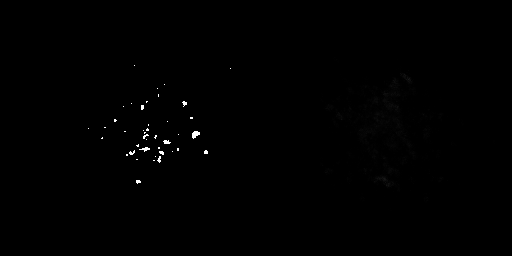

0.0


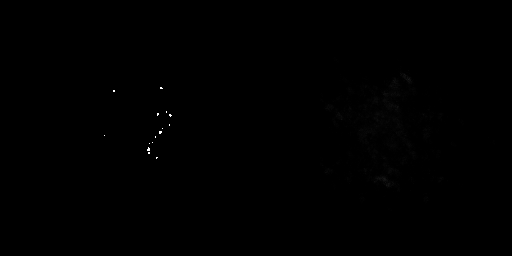

0.0


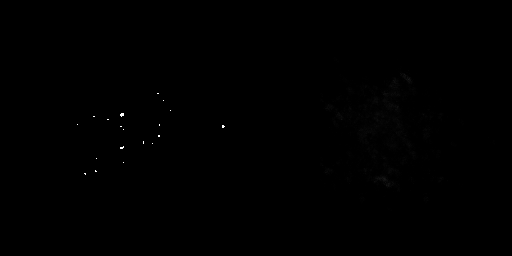

0.0


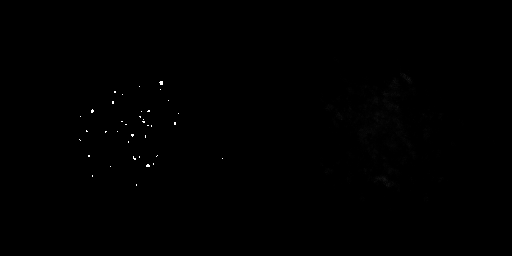

0.0


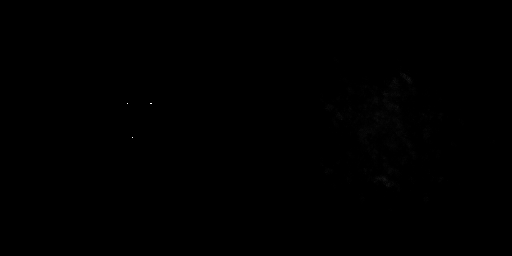

0.0


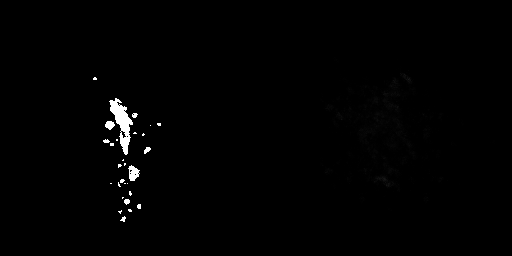

0.0


0.0

In [ ]:
#@title Generate predictions and validate with Jaccard similarity


y_pred = model.predict(np.asarray(X_test))

succ = []
for i in range(len(y_pred)):
  cv2_imshow(np.concatenate((y_test[i], y_pred[i]), axis = 1)*255)
  jacc = np.logical_and(y_test[i], y_pred[i]>0.5).sum()/np.logical_or(y_test[i], y_pred[i]>0.5).sum()

  succ.append(jacc)
  print(jacc)


print(np.average(succ))